## Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from graphviz import Graph
from sklearn import preprocessing
import math
from collections import defaultdict
from est_MI import est_MI_JVHW

## Data Reading
We are using alarm dataset with 37 features and 10000 measurements
The dataset details: https://rdrr.io/cran/bnlearn/man/alarm.html


In [2]:
df = pd.read_csv('alarm10K.csv')
features = 37
num_data = 10000
data = np.array(df)

## Data Processing: Finding the joint and marginal PMFs

In [3]:
#We use dictionaries to store the marginal and joint pmfs
joint_pmf = {}
marginal_pmf = {}

for i in range(features):
    marginal_pmf[i] = defaultdict(float)
    for j in range(i+1, features):
        joint_pmf[(i, j)] = defaultdict(float)

count_aggr = 0

for k in range(num_data):   
    count_aggr += 1
    for i in range(features):
        marginal_pmf[i][(data[k][i])] += 1./num_data
        for j in range(i+1, features):
            joint_pmf[(i,j)][(data[k][i], data[k][j])] += 1./num_data

## Plugin estimator Mutual Information
We are creating an adjacency Matrix containig Plugin estimator values of Mutual Information. This is stored in 2D array I.

$$I(U;V) = \sum_{u \in U} \sum_{v \in V}P_{UV}(u,v)log(\frac{P_{UV}(u,v)}{P_{U}(u)P_{V}(v)})$$

In [4]:
I = []
for i in range(features):
    row = []
    for j in range(features):
        row.append(0)
    I.append(row)    

for i in range(features):
    for j in range(i+1, features):
        var = 0
        for U, P_U in marginal_pmf[i].items():
            for V, P_V in marginal_pmf[j].items():
                if (U, V) in joint_pmf[(i, j)]:
                    P_UV = joint_pmf[(i, j)][(U, V)]
                    t = (P_UV/(P_U*P_V))
                    var += P_UV*(math.log(t, 2))
        I[i][j]=var
        I[j][i]=var
                    

## JVHW Mutual Information 
Code from https://github.com/EEthinker/JVHW_Entropy_Estimators

Other required python files for implementation from this repo is added to the submisssion repository

In [5]:
MI_JVHW = np.zeros((features,features))
labelEncoder = preprocessing.LabelEncoder()
for i in range(features):
    for j in range(features):
        if i!=j:
            X = labelEncoder.fit_transform(df[df.columns[i]])
            Y = labelEncoder.fit_transform(df[df.columns[j]])
            I_JVHW = est_MI_JVHW(X, Y)
            MI_JVHW[i,j] = I_JVHW

## Prim's Algorithm
Input: Adjacency matrix of the graph 

Return: Edges of MST along with weights 

Code base used: https://coderbyte.com/algorithm/find-minimum-spanning-tree-using-prims-algorithm with slight modification to suit the purpose.

In [7]:
def prims(V, adjMatrix):

    vertex = 0
    MST = []
    edges = []
    visited = []
    maxEdge = [None,None,0]

    while (len(MST) != V-1):
        
        visited.append(vertex)
        
        for r in range(0, V):
            if adjMatrix[vertex][r] != 0:
                edges.append([vertex,r,adjMatrix[vertex][r]])

        for e in range(0, len(edges)):
            if edges[e][2] > maxEdge[2] and edges[e][1] not in visited:
                maxEdge = edges[e]

        edges.remove(maxEdge)
        MST.append(maxEdge)
        vertex = maxEdge[1]
        maxEdge = [None,None,0]

    return MST

## Tree obtained from JVHW Estimator
Visualized using Graphviz visualisation

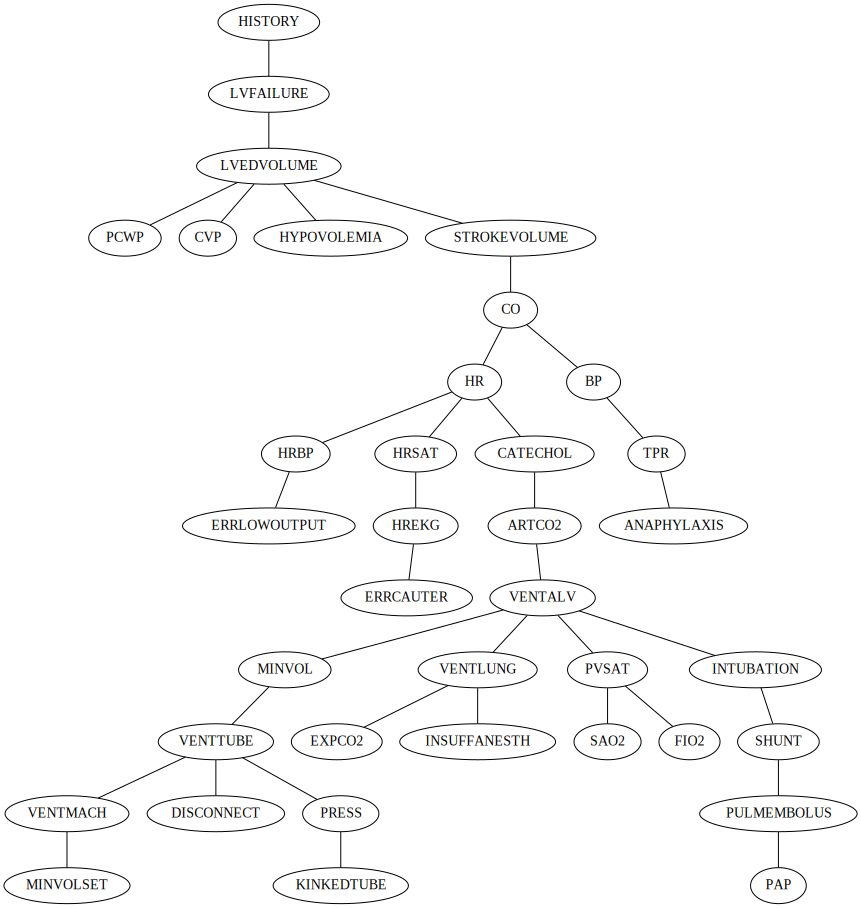

In [28]:
BN_JVHW =prims(features,MI_JVHW)
treeJVHW = Graph()
visited=[]
for i in range(len(BN_JVHW)):
    a,b,weight = BN_JVHW[i]
    if not [b,a] in visited:
        treeJVHW.edge(df.columns[a],df.columns[b])
        visited.append([a,b])
treeJVHW

## Tree obtained from Plugin Estimator
Visualized using Graphviz visualisation

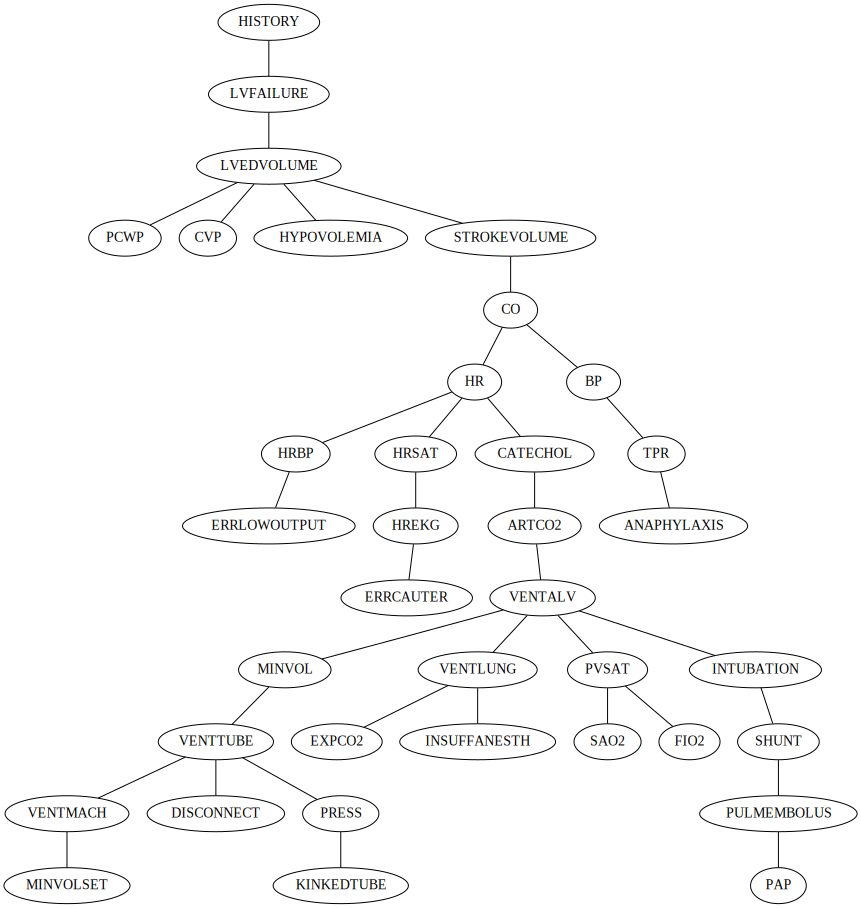

In [27]:
BN_plugin=prims(features,I)
tree = Graph()
visited=[]
for i in range(len(BN_plugin)):
    a,b,weight = BN_plugin[i]
    if not [b,a] in visited:
        tree.edge(df.columns[a],df.columns[b])
        visited.append([a,b])
tree

In [30]:
tree.render('TreeImages/plugin_BN',view=True)  #Save Data
treeJVHW.render('TreeImages/JVHW_BN',view=True)

'TreeImages\\JVHW_BN.pdf'

## Comparing the two estimators
Since the data is distance measures, to compute the difference we can use the simple L1-norm. After running we can see that the value of L1 norm is considerably low indicating that both the graphs are almost similar for large N

In [32]:
def l1norm(x1,x2):
    l1norm=0
    for i in range(len(x1)):
        l1norm += np.abs(x1[i][2]-x2[i][2])
    return l1norm

print(l1norm(BN_JVHW,BN_plugin))

0.007904212488153222
